In [252]:
import pandas as pd
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
#https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
%matplotlib inline

### Model Evaluation Approach

In [253]:
# random state for reproducing same results
random_state = 54321

In [254]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [255]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [256]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

### Word Embeddings start

In [257]:
# load data
df = pd.read_csv(r"C:\Masters\Masters in Data Science\Research\EDA\Data\Revised Data\FinalData\Google_Cloud\2HVSingleTextClassification_v2.txt", sep = "\t", names=["tag", "plot"])
df.head()

,tag,plot
0,Other,Life is a song - sing it. Life is a game - pla...
1,Love,Life is love - enjoy it.
2,Right_Conduct,"Do not use poisonous words against anyone, for..."
3,Other,The end of education is character
4,Other,"As worldly thoughts diminish, thoughts of God ..."


In [258]:
## - shuffle the pack to create a random and unbiased split of the dataset
import random
from sklearn.utils import shuffle
df = shuffle(df)
#train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data_df, test_data_df = train_test_split(df, test_size=0.2, random_state=random_state)


In [259]:
print(len(train_data_df))
print(len(test_data_df))

539
135


In [260]:
#https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b
#https://github.com/TomLin/Playground/blob/master/UtilWordEmbedding.py
class DocPreprocess(object):

	def __init__(self,
				 nlp,
				 stop_words,
				 docs,
				 labels,
				 build_bi=False,
				 min_count=5,
				 threshold=10,
				 allowed_postags=['ADV', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'NUM']):

		self.nlp = nlp  # spacy nlp object
		self.stop_words = stop_words  # spacy.lang.en.stop_words.STOP_WORDS
		self.docs = docs  # docs must be either list or numpy array or series of docs
		self.labels = labels # labels must be list or or numpy array or series of labels
		self.doc_ids = np.arange(len(docs))
		self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in self.docs]

		if build_bi:
			self.bi_detector = self.build_bi_detect(self.simple_doc_tokens, min_count=min_count, threshold=threshold)
			self.new_docs = self.make_bigram_doc(self.bi_detector, self.simple_doc_tokens)
		else:
			self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
		self.doc_words = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]
		self.tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(self.doc_words, self.doc_ids)]


	def build_bi_detect(self, simple_doc_tokens, min_count, threshold):
		bi_ = gensim.models.phrases.Phrases(simple_doc_tokens, min_count=min_count, threshold=threshold)
		bi_detector = gensim.models.phrases.Phraser(bi_)  # wrapper enhance efficiency
		return bi_detector


	def make_bigram_doc(self, bi_detector, simple_doc_tokens):
		bi_doc_tokens = [bi_detector[doc_tokens] for doc_tokens in simple_doc_tokens]
		bi_docs = []
		for bi_tokens in bi_doc_tokens:
			bi_doc = " ".join(bi_tokens)  # concatenate back to a sentence
			bi_docs.append(bi_doc)
		return bi_docs


	def make_simple_doc(self, simple_doc_tokens):
		simple_docs = []
		for doc_tokens in simple_doc_tokens:
			simple = " ".join(doc_tokens)  # concatenate back to a sentence
			simple_docs.append(simple)
		return simple_docs


	def lemmatize(self, doc, allowed_postags):
		"""
		Lemmatize words and remove stop_words.
		:param doc: text
		:param allowed_postags: list of pos tags
		:return:
			list of tokens
		"""
		doc = self.nlp(doc)
		tokens = [token.lemma_ for token in doc if (
				token.pos_ in allowed_postags) and (token.text not in self.stop_words)]
		return tokens



### Word2Vec

In [261]:
from gensim.models import Word2Vec
import spacy

wv = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

2020-01-12 19:02:36,901 : INFO : loading projection weights from C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz
2020-01-12 19:05:11,414 : INFO : loaded (3000000, 300) matrix from C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz
2020-01-12 19:05:16,925 : INFO : precomputing L2-norms of word weight vectors


In [262]:
#CBOW Word Averaging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [263]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 3:
                continue
            if word in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

In [264]:
test_tokenized = test_data_df.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data_df.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values

In [265]:
##%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [266]:
class TfidfEmbeddingVectorizer(object):
     def __init__(self, word_model):
        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size
    def fit(self, docs):  # comply with scikit-learn transformer requirement
        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))
        tfidf = TfidfVectorizer()
        tfidf.fit(text_docs)  
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        self.word_idf_weight = defaultdict(lambda: max_idf,
                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self
    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector
    def word_average(self, sent):
        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted
        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean
    def word_average_list(self, docs):
        return np.vstack([self.word_average(sent) for sent in docs])

In [267]:
from collections import defaultdict
word_model = Word2Vec(test_tokenized, min_count=2, size=300, window=5, iter=100)
tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)
tfidf_vec_tr.fit(test_tokenized)  # fit tfidf model first
X_test_W2V_TFIDF = tfidf_vec_tr.transform(test_tokenized)

word_model = Word2Vec(train_tokenized, min_count=2, size=300, window=5, iter=100)
tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)
tfidf_vec_tr.fit(train_tokenized)  # fit tfidf model first
X_train_W2V_TFIDF = tfidf_vec_tr.transform(train_tokenized)

2020-01-12 19:06:21,742 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-01-12 19:06:21,762 : INFO : collecting all words and their counts
2020-01-12 19:06:21,766 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-12 19:06:21,770 : INFO : collected 2149 word types from a corpus of 5048 raw words and 135 sentences
2020-01-12 19:06:21,773 : INFO : Loading a fresh vocabulary
2020-01-12 19:06:21,779 : INFO : effective_min_count=2 retains 776 unique words (36% of original 2149, drops 1373)
2020-01-12 19:06:21,782 : INFO : effective_min_count=2 leaves 3675 word corpus (72% of original 5048, drops 1373)
2020-01-12 19:06:21,791 : INFO : deleting the raw counts dictionary of 2149 items
2020-01-12 19:06:21,793 : INFO : sample=0.001 downsamples 63 most-common words
2020-01-12 19:06:21,795 : INFO : downsampling leaves estimated 3081 word corpus (83.9% of prior 3675)
2020-01-12 19:06:21,801 : INFO : estimated required memory for

2020-01-12 19:06:22,242 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:22,248 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:22,250 : INFO : EPOCH - 18 : training on 5048 raw words (3088 effective words) took 0.0s, 254125 effective words/s
2020-01-12 19:06:22,255 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:22,258 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:22,264 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:22,266 : INFO : EPOCH - 19 : training on 5048 raw words (3067 effective words) took 0.0s, 252610 effective words/s
2020-01-12 19:06:22,271 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:22,274 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:22,280 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-

2020-01-12 19:06:22,571 : INFO : EPOCH - 38 : training on 5048 raw words (3053 effective words) took 0.0s, 270978 effective words/s
2020-01-12 19:06:22,576 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:22,578 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:22,584 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:22,586 : INFO : EPOCH - 39 : training on 5048 raw words (3090 effective words) took 0.0s, 266169 effective words/s
2020-01-12 19:06:22,591 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:22,594 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:22,601 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:22,603 : INFO : EPOCH - 40 : training on 5048 raw words (3102 effective words) took 0.0s, 242886 effective words/s
2020-01-12 19:06:22,610 : INFO : worker thread finished; a

2020-01-12 19:06:22,974 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:22,977 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:22,984 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:22,985 : INFO : EPOCH - 59 : training on 5048 raw words (3106 effective words) took 0.0s, 233436 effective words/s
2020-01-12 19:06:22,992 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:22,994 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:23,000 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:23,001 : INFO : EPOCH - 60 : training on 5048 raw words (3050 effective words) took 0.0s, 272218 effective words/s
2020-01-12 19:06:23,007 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:23,010 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-

2020-01-12 19:06:23,313 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:23,316 : INFO : EPOCH - 79 : training on 5048 raw words (3108 effective words) took 0.0s, 217006 effective words/s
2020-01-12 19:06:23,321 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:23,323 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:23,329 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:23,331 : INFO : EPOCH - 80 : training on 5048 raw words (3081 effective words) took 0.0s, 272283 effective words/s
2020-01-12 19:06:23,336 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:23,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:23,343 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:23,345 : INFO : EPOCH - 81 : training on 5048 raw words (3091 effective words) too

2020-01-12 19:06:23,640 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:23,642 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:23,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:23,651 : INFO : EPOCH - 100 : training on 5048 raw words (3082 effective words) took 0.0s, 223056 effective words/s
2020-01-12 19:06:23,654 : INFO : training on a 504800 raw words (308352 effective words) took 1.8s, 169597 effective words/s
2020-01-12 19:06:24,019 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-01-12 19:06:24,021 : INFO : collecting all words and their counts
2020-01-12 19:06:24,024 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-12 19:06:24,032 : INFO : collected 4546 word types from a corpus of 18367 raw words and 539 sentences
2020-01-12 19:06:24,034 : INFO : Loading a fresh vocabulary
2020-01-12 19:06:24,04

2020-01-12 19:06:24,672 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:24,691 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:24,695 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:24,697 : INFO : EPOCH - 17 : training on 18367 raw words (14011 effective words) took 0.0s, 481974 effective words/s
2020-01-12 19:06:24,706 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:24,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:24,730 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:24,733 : INFO : EPOCH - 18 : training on 18367 raw words (13953 effective words) took 0.0s, 467721 effective words/s
2020-01-12 19:06:24,740 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:24,761 : INFO : worker thread finished; awaiting finish of 1 more threads
2020

2020-01-12 19:06:25,406 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:25,409 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:25,411 : INFO : EPOCH - 37 : training on 18367 raw words (13994 effective words) took 0.0s, 423983 effective words/s
2020-01-12 19:06:25,426 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:25,449 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:25,452 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:25,454 : INFO : EPOCH - 38 : training on 18367 raw words (14036 effective words) took 0.0s, 418677 effective words/s
2020-01-12 19:06:25,466 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:25,489 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:25,491 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-01-12 19:06:26,129 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:26,131 : INFO : EPOCH - 57 : training on 18367 raw words (13976 effective words) took 0.0s, 469752 effective words/s
2020-01-12 19:06:26,140 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:26,160 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:26,162 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:26,164 : INFO : EPOCH - 58 : training on 18367 raw words (14032 effective words) took 0.0s, 486853 effective words/s
2020-01-12 19:06:26,174 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:26,194 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:26,196 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:26,198 : INFO : EPOCH - 59 : training on 18367 raw words (13981 effective word

2020-01-12 19:06:26,797 : INFO : EPOCH - 77 : training on 18367 raw words (13975 effective words) took 0.0s, 493066 effective words/s
2020-01-12 19:06:26,806 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:26,823 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:26,828 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:26,831 : INFO : EPOCH - 78 : training on 18367 raw words (13995 effective words) took 0.0s, 483655 effective words/s
2020-01-12 19:06:26,840 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:26,860 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:26,863 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:26,866 : INFO : EPOCH - 79 : training on 18367 raw words (14001 effective words) took 0.0s, 472455 effective words/s
2020-01-12 19:06:26,875 : INFO : worker thread finis

2020-01-12 19:06:27,497 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:27,518 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:27,519 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:27,520 : INFO : EPOCH - 98 : training on 18367 raw words (14012 effective words) took 0.0s, 506768 effective words/s
2020-01-12 19:06:27,530 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:27,549 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:27,553 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:27,554 : INFO : EPOCH - 99 : training on 18367 raw words (14044 effective words) took 0.0s, 513564 effective words/s
2020-01-12 19:06:27,565 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:27,585 : INFO : worker thread finished; awaiting finish of 1 more threads
2020

In [268]:
#Datasets
#X_train, X_test, y_train, y_test
#CBOW - WordAvg - X_train_word_average, X_test_word_average, train_data_df.tag, test_data_df.tag
#CBOW -TF-IDF - X_train_W2V_TFIDF, X_test_W2V_TFIDF,train_data_df.tag, test_data_df.tag


In [269]:
print(len(X_test_W2V_TFIDF))
print(len(test_data_df.tag))

135
135


In [270]:
### Word2Vec simple implementation

In [271]:
new_word2vec_df = df

In [272]:
# imports needed and logging
import gensim 
import spacy
from gensim.models.doc2vec import TaggedDocument

nlp = spacy.load(r'C:\Users\425858\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.5', disable=['parser', 'ner'])
stop_words = spacy.lang.en.stop_words.STOP_WORDS


In [273]:
new_word2vec_df.head()

,tag,plot
369,Right_Conduct,To seek only your future is selfishness. To be...
131,Right_Conduct,The Purāñas (scriptures) consider moksha (libe...
324,Love,There are many ways of realising God. Among th...
653,Other,Have faith that truth will save you in the lon...
410,Other,"You may chant any Name, contemplate on any for..."


In [274]:
all_docs = DocPreprocess(nlp, stop_words, new_word2vec_df['plot'], new_word2vec_df['tag'])

In [275]:
type(all_docs)

__main__.DocPreprocess

In [276]:
len(all_docs.tagdocs)

674

In [277]:
all_docs.tagdocs[4]


TaggedDocument(words=['chant', 'contemplate', 'form', 'understand', 'truth', 'god'], tags=[4])

In [278]:
all_docs.labels.iloc[4]

'Other'

In [279]:
simple_word_model = Word2Vec(all_docs.doc_words, min_count=2, size=300, workers=3, window=5, iter=100)


2020-01-12 19:06:34,264 : INFO : collecting all words and their counts
2020-01-12 19:06:34,267 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-12 19:06:34,276 : INFO : collected 3523 word types from a corpus of 19012 raw words and 674 sentences
2020-01-12 19:06:34,278 : INFO : Loading a fresh vocabulary
2020-01-12 19:06:34,287 : INFO : effective_min_count=2 retains 1901 unique words (53% of original 3523, drops 1622)
2020-01-12 19:06:34,290 : INFO : effective_min_count=2 leaves 17390 word corpus (91% of original 19012, drops 1622)
2020-01-12 19:06:34,301 : INFO : deleting the raw counts dictionary of 3523 items
2020-01-12 19:06:34,302 : INFO : sample=0.001 downsamples 57 most-common words
2020-01-12 19:06:34,303 : INFO : downsampling leaves estimated 15038 word corpus (86.5% of prior 17390)
2020-01-12 19:06:34,311 : INFO : estimated required memory for 1901 words and 300 dimensions: 5512900 bytes
2020-01-12 19:06:34,313 : INFO : resetting layer weight

2020-01-12 19:06:35,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:35,117 : INFO : EPOCH - 18 : training on 19012 raw words (15027 effective words) took 0.0s, 423663 effective words/s
2020-01-12 19:06:35,125 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:35,151 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:35,156 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:35,157 : INFO : EPOCH - 19 : training on 19012 raw words (15008 effective words) took 0.0s, 421645 effective words/s
2020-01-12 19:06:35,168 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:35,193 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:35,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:35,200 : INFO : EPOCH - 20 : training on 19012 raw words (15066 effective word

2020-01-12 19:06:36,009 : INFO : EPOCH - 38 : training on 19012 raw words (15056 effective words) took 0.0s, 386801 effective words/s
2020-01-12 19:06:36,019 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:36,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:36,052 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:36,054 : INFO : EPOCH - 39 : training on 19012 raw words (15042 effective words) took 0.0s, 395794 effective words/s
2020-01-12 19:06:36,066 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:36,090 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:36,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:36,095 : INFO : EPOCH - 40 : training on 19012 raw words (15073 effective words) took 0.0s, 402048 effective words/s
2020-01-12 19:06:36,105 : INFO : worker thread finis

2020-01-12 19:06:36,836 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:36,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:36,867 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:36,868 : INFO : EPOCH - 59 : training on 19012 raw words (15042 effective words) took 0.0s, 428717 effective words/s
2020-01-12 19:06:36,877 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:36,905 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:36,909 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:36,911 : INFO : EPOCH - 60 : training on 19012 raw words (15096 effective words) took 0.0s, 404307 effective words/s
2020-01-12 19:06:36,919 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:36,946 : INFO : worker thread finished; awaiting finish of 1 more threads
2020

2020-01-12 19:06:37,687 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:37,694 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:37,696 : INFO : EPOCH - 79 : training on 19012 raw words (15050 effective words) took 0.0s, 411125 effective words/s
2020-01-12 19:06:37,708 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:37,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:37,739 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:37,741 : INFO : EPOCH - 80 : training on 19012 raw words (15043 effective words) took 0.0s, 391443 effective words/s
2020-01-12 19:06:37,752 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:37,783 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:37,785 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-01-12 19:06:38,537 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:38,538 : INFO : EPOCH - 99 : training on 19012 raw words (15050 effective words) took 0.0s, 473883 effective words/s
2020-01-12 19:06:38,552 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:38,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:38,577 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:38,579 : INFO : EPOCH - 100 : training on 19012 raw words (15080 effective words) took 0.0s, 409179 effective words/s
2020-01-12 19:06:38,583 : INFO : training on a 1901200 raw words (1503974 effective words) took 4.2s, 355934 effective words/s


In [280]:
simple_word_model.init_sims(replace=True) #Training stops


2020-01-12 19:06:38,602 : INFO : precomputing L2-norms of word weight vectors


In [281]:
for i, word in enumerate(simple_word_model.wv.vocab):
    if i == 10:
        break
    print(word)

seek
future
selfishness
concerned
bliss
human
give
selfinter
regard
happiness


In [282]:
target_labels = all_docs.labels
discourse_data = all_docs.docs


In [283]:
print(discourse_data.head())

369    To seek only your future is selfishness. To be...
131    The Purāñas (scriptures) consider moksha (libe...
324    There are many ways of realising God. Among th...
653    Have faith that truth will save you in the lon...
410    You may chant any Name, contemplate on any for...
Name: plot, dtype: object


In [284]:
simple_word_model.wv.most_similar("love")

[('recipient', 0.5943304896354675),
 ('form', 0.5760985016822815),
 ('reside', 0.5658792853355408),
 ('flood', 0.5599507093429565),
 ('divine', 0.5594161748886108),
 ('incessantly', 0.5510051250457764),
 ('unseen', 0.5273304581642151),
 ('bestow', 0.5268000364303589),
 ('flow', 0.513245701789856),
 ('hridaya', 0.5069131851196289)]

In [285]:
#from gensim import models
#from sklearn.feature_extraction.text import TfidfVectorizer
#https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76
#messages = [w2v_tokenize_text(message) for message in discourse_data]
#Use for Thesis writing
#Add TF-IDF here
#target_labels = all_docs.labels
#discourse_data = all_docs.docs

In [286]:
#simple_word2Vec = word_averaging_list(simple_word_model,messages)
#https://www.quora.com/How-do-you-extract-vectors-from-word2vec-given-a-word

### Doc2Vec

In [287]:
train_data = train_data_df
test_data = test_data_df

In [288]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [289]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [290]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [291]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [292]:
test_tagged.values[30]


TaggedDocument(words=['what', 'has', 'to', 'be', 'borne', 'in', 'mind', 'is', 'this', 'indian', 'bharathiya', 'texts', 'on', 'spirituality', 'are', 'the', 'most', 'ancient', 'in', 'the', 'whole', 'world', 'they', 'are', 'the', 'earliest', 'studies', 'and', 'discoveries', 'of', 'the', 'atma', 'of', 'personal', 'and', 'impersonal', 'god', 'and', 'of', 'codes', 'of', 'conduct', 'individual', 'and', 'social', 'based', 'on', 'those', 'revelations', 'and', 'discoveries', 'in', 'no', 'other', 'country', 'among', 'no', 'other', 'peoples', 'have', 'such', 'ancient', 'teachings', 'seen', 'the', 'light', 'there', 'may', 'be', 'some', 'misty', 'ideas', 'or', 'brief', 'glimpses', 'but', 'they', 'do', 'not', 'deserve', 'the', 'name', 'spiritual', 'text', 'or', 'literature', 'the', 'vedic', 'literature', 'pictures', 'not', 'only', 'spiritual', 'inquiries', 'by', 'the', 'sages', 'and', 'spiritual', 'aspirants', 'and', 'their', 'results', 'but', 'also', 'their', 'lines', 'of', 'thought', 'their', 'year

In [293]:
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=300, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2020-01-12 19:06:39,720 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-01-12 19:06:39,733 : INFO : collecting all words and their counts
2020-01-12 19:06:39,736 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-12 19:06:39,749 : INFO : collected 4251 word types and 3 unique tags from a corpus of 539 examples and 33869 words
2020-01-12 19:06:39,751 : INFO : Loading a fresh vocabulary
2020-01-12 19:06:39,756 : INFO : effective_min_count=5 retains 830 unique words (19% of original 4251, drops 3421)
2020-01-12 19:06:39,759 : INFO : effective_min_count=5 leaves 28374 word corpus (83% of original 33869, drops 5495)
2020-01-12 19:06:39,768 : INFO : deleting the raw counts dictionary of 4251 items
2020-01-12 19:06:39,769 : INFO : sample=0.001 downsamples 58 most-common words
2020-01-12 19:06:39,771 : INFO : downsampling leaves estimated 17410 word corpus (61.4% of prior 28374)
2020-01-12 19:06:39,774 : INFO : estima

In [294]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

In [295]:
#Doc2Vec dataset
#X_train, X_test, y_train, y_test format
#Doc2Vec - train_regressors, test_regressors, train_targets, test_targets


### Deep IR

In [296]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")

In [297]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tag'],\
        'x':[clean(s).split() for s in sentences(row['plot'])]}

In [298]:
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

In [299]:
# shuffle training set for unbiased word2vec training
#np.random.shuffle(revtrain)

In [300]:
my_tags = df.tag.unique()

def tag_sentences(reviews, stars=my_tags):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

In [301]:
next(tag_sentences(revtrain, my_tags[0]))


['if',
 'you',
 'honour',
 'your',
 'mother',
 'the',
 'mother',
 'of',
 'the',
 'universe',
 'will',
 'guard',
 'you',
 'against',
 'harm']

In [302]:
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train( slist, total_examples=len(slist), epochs=basemodel.epochs)
# get the probs (note we give docprob a list of lists of words, plus the models)

Word2Vec(vocab=0, size=100, alpha=0.025)


2020-01-12 19:06:42,156 : INFO : collecting all words and their counts
2020-01-12 19:06:42,158 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-12 19:06:42,177 : INFO : collected 4247 word types from a corpus of 34066 raw words and 3129 sentences
2020-01-12 19:06:42,179 : INFO : Loading a fresh vocabulary
2020-01-12 19:06:42,184 : INFO : effective_min_count=5 retains 840 unique words (19% of original 4247, drops 3407)
2020-01-12 19:06:42,185 : INFO : effective_min_count=5 leaves 28572 word corpus (83% of original 34066, drops 5494)
2020-01-12 19:06:42,193 : INFO : deleting the raw counts dictionary of 4247 items
2020-01-12 19:06:42,195 : INFO : sample=0.001 downsamples 59 most-common words
2020-01-12 19:06:42,197 : INFO : downsampling leaves estimated 17695 word corpus (61.9% of prior 28572)
2020-01-12 19:06:42,199 : INFO : constructing a huffman tree from 840 words
2020-01-12 19:06:42,229 : INFO : built huffman tree with maximum node depth 13
2020-01-

Right_Conduct genre ( 995 )


2020-01-12 19:06:42,339 : INFO : training model with 4 workers on 840 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2020-01-12 19:06:42,350 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:42,355 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:42,357 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:42,362 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:42,364 : INFO : EPOCH - 1 : training on 12001 raw words (6235 effective words) took 0.0s, 363607 effective words/s
2020-01-12 19:06:42,373 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:42,376 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:42,378 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:42,385 : INFO : worker thread finished; awaiting finish of 0 more 

2020-01-12 19:06:42,739 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:42,745 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:42,747 : INFO : EPOCH - 17 : training on 12001 raw words (6308 effective words) took 0.0s, 301277 effective words/s
2020-01-12 19:06:42,756 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:42,759 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:42,760 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:42,767 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:42,769 : INFO : EPOCH - 18 : training on 12001 raw words (6320 effective words) took 0.0s, 395860 effective words/s
2020-01-12 19:06:42,777 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:42,780 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-01-12 19:06:43,144 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:43,148 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:43,149 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:43,156 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:43,158 : INFO : EPOCH - 34 : training on 12001 raw words (6323 effective words) took 0.0s, 337632 effective words/s
2020-01-12 19:06:43,169 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:43,175 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:43,176 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:43,182 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:43,184 : INFO : EPOCH - 35 : training on 12001 raw words (6323 effective words) took 0.0s, 320334 effective words/s
2020-0

2020-01-12 19:06:43,601 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:43,603 : INFO : EPOCH - 50 : training on 12001 raw words (6285 effective words) took 0.0s, 296237 effective words/s
2020-01-12 19:06:43,615 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:43,621 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:43,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:43,628 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:43,631 : INFO : EPOCH - 51 : training on 12001 raw words (6270 effective words) took 0.0s, 288948 effective words/s
2020-01-12 19:06:43,642 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:43,646 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:43,648 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-01-12 19:06:44,014 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:44,017 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,021 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:44,022 : INFO : EPOCH - 67 : training on 12001 raw words (6264 effective words) took 0.0s, 352814 effective words/s
2020-01-12 19:06:44,031 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:44,034 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:44,036 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,043 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:44,045 : INFO : EPOCH - 68 : training on 12001 raw words (6292 effective words) took 0.0s, 353232 effective words/s
2020-01-12 19:06:44,055 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-01-12 19:06:44,396 : INFO : EPOCH - 83 : training on 12001 raw words (6301 effective words) took 0.0s, 365559 effective words/s
2020-01-12 19:06:44,406 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:44,409 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:44,411 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,416 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:44,418 : INFO : EPOCH - 84 : training on 12001 raw words (6298 effective words) took 0.0s, 373610 effective words/s
2020-01-12 19:06:44,430 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:44,435 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:44,436 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,443 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-01-12 19:06:44,792 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,798 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:44,799 : INFO : EPOCH - 100 : training on 12001 raw words (6382 effective words) took 0.0s, 369537 effective words/s
2020-01-12 19:06:44,800 : INFO : training on a 1200100 raw words (629845 effective words) took 2.5s, 256111 effective words/s


Love genre ( 1613 )


2020-01-12 19:06:44,811 : INFO : training model with 4 workers on 840 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2020-01-12 19:06:44,822 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:44,827 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:44,833 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,835 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:44,836 : INFO : EPOCH - 1 : training on 16263 raw words (8365 effective words) took 0.0s, 474352 effective words/s
2020-01-12 19:06:44,850 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:44,856 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:44,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:44,863 : INFO : worker thread finished; awaiting finish of 0 more 

2020-01-12 19:06:45,270 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:45,273 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:45,275 : INFO : EPOCH - 17 : training on 16263 raw words (8431 effective words) took 0.0s, 336887 effective words/s
2020-01-12 19:06:45,287 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:45,302 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:45,304 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:45,305 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:45,306 : INFO : EPOCH - 18 : training on 16263 raw words (8397 effective words) took 0.0s, 363248 effective words/s
2020-01-12 19:06:45,321 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:45,329 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-01-12 19:06:45,769 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:45,779 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:45,783 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:45,784 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:45,786 : INFO : EPOCH - 34 : training on 16263 raw words (8465 effective words) took 0.0s, 422260 effective words/s
2020-01-12 19:06:45,795 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:45,799 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:45,806 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:45,808 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:45,811 : INFO : EPOCH - 35 : training on 16263 raw words (8453 effective words) took 0.0s, 423908 effective words/s
2020-0

2020-01-12 19:06:46,209 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:46,210 : INFO : EPOCH - 50 : training on 16263 raw words (8417 effective words) took 0.0s, 444943 effective words/s
2020-01-12 19:06:46,220 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:46,223 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:46,231 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:46,233 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:46,236 : INFO : EPOCH - 51 : training on 16263 raw words (8442 effective words) took 0.0s, 415333 effective words/s
2020-01-12 19:06:46,247 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:46,252 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:46,258 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-01-12 19:06:46,646 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:46,650 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:46,654 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:46,655 : INFO : EPOCH - 67 : training on 16263 raw words (8403 effective words) took 0.0s, 390011 effective words/s
2020-01-12 19:06:46,665 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:46,670 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:46,675 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:46,680 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:46,682 : INFO : EPOCH - 68 : training on 16263 raw words (8406 effective words) took 0.0s, 398458 effective words/s
2020-01-12 19:06:46,692 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-01-12 19:06:47,093 : INFO : EPOCH - 83 : training on 16263 raw words (8491 effective words) took 0.0s, 380258 effective words/s
2020-01-12 19:06:47,103 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:47,108 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:47,114 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,116 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:47,118 : INFO : EPOCH - 84 : training on 16263 raw words (8495 effective words) took 0.0s, 424774 effective words/s
2020-01-12 19:06:47,131 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:47,136 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:47,142 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,144 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-01-12 19:06:47,535 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,537 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:47,539 : INFO : EPOCH - 100 : training on 16263 raw words (8460 effective words) took 0.0s, 365630 effective words/s
2020-01-12 19:06:47,542 : INFO : training on a 1626300 raw words (843040 effective words) took 2.7s, 308926 effective words/s


Other genre ( 521 )


2020-01-12 19:06:47,554 : INFO : training model with 4 workers on 840 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2020-01-12 19:06:47,564 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:47,568 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:47,571 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,573 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:47,576 : INFO : EPOCH - 1 : training on 5802 raw words (2934 effective words) took 0.0s, 191808 effective words/s
2020-01-12 19:06:47,585 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:47,588 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:47,589 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,593 : INFO : worker thread finished; awaiting finish of 0 more t

2020-01-12 19:06:47,889 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,893 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:47,895 : INFO : EPOCH - 17 : training on 5802 raw words (2953 effective words) took 0.0s, 164395 effective words/s
2020-01-12 19:06:47,904 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:47,906 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:47,908 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:47,911 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:47,913 : INFO : EPOCH - 18 : training on 5802 raw words (2976 effective words) took 0.0s, 247211 effective words/s
2020-01-12 19:06:47,923 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:47,925 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-

2020-01-12 19:06:48,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:48,184 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:48,186 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:48,189 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:48,191 : INFO : EPOCH - 34 : training on 5802 raw words (2966 effective words) took 0.0s, 287034 effective words/s
2020-01-12 19:06:48,198 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:48,200 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:48,202 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:48,206 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:48,207 : INFO : EPOCH - 35 : training on 5802 raw words (2979 effective words) took 0.0s, 265163 effective words/s
2020-01-

2020-01-12 19:06:48,480 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:48,482 : INFO : EPOCH - 50 : training on 5802 raw words (2997 effective words) took 0.0s, 246519 effective words/s
2020-01-12 19:06:48,490 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:48,492 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:48,493 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:48,497 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:48,498 : INFO : EPOCH - 51 : training on 5802 raw words (2948 effective words) took 0.0s, 244045 effective words/s
2020-01-12 19:06:48,508 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:48,509 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:48,512 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-

2020-01-12 19:06:48,782 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:48,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:48,788 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:48,789 : INFO : EPOCH - 67 : training on 5802 raw words (2966 effective words) took 0.0s, 228631 effective words/s
2020-01-12 19:06:48,803 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:48,807 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:48,809 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:48,811 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:48,814 : INFO : EPOCH - 68 : training on 5802 raw words (2984 effective words) took 0.0s, 214006 effective words/s
2020-01-12 19:06:48,824 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-

2020-01-12 19:06:49,183 : INFO : EPOCH - 83 : training on 5802 raw words (2980 effective words) took 0.0s, 243453 effective words/s
2020-01-12 19:06:49,191 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:49,193 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:49,196 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:49,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:49,201 : INFO : EPOCH - 84 : training on 5802 raw words (2962 effective words) took 0.0s, 244955 effective words/s
2020-01-12 19:06:49,210 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-12 19:06:49,213 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:49,215 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:49,219 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-

2020-01-12 19:06:49,497 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:49,500 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:49,503 : INFO : EPOCH - 100 : training on 5802 raw words (2988 effective words) took 0.0s, 234934 effective words/s
2020-01-12 19:06:49,505 : INFO : training on a 580200 raw words (296417 effective words) took 2.0s, 151978 effective words/s


In [303]:
def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [304]:
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2020-01-12 19:06:49,541 : INFO : scoring sentences with 4 workers on 840 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2020-01-12 19:06:49,552 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2020-01-12 19:06:49,568 : INFO : scoring 786 sentences took 0.0s, 36317 sentences/s
2020-01-12 19:06:49,570 : INFO : scoring sentences with 4 workers on 840 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2020-01-12 19:06:49,573 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2020-01-12 19:06:49,586 : INFO : scoring 786 sentences took 0.0s, 53633 sentences/s
2020-01-12 19:06:49,587 : INFO : scoring sentences with 4 workers on 840 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2020-01-12 19:06:49,591 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2020-01-12 19:06:49,605 : INFO : scoring 786 sentences took 0.0s, 47531 sentences/s


In [305]:
print(revtrain)

[{'y': 'Love', 'x': [['there', 'is', 'only', 'one', 'caste', 'the', 'caste', 'of', 'humanity'], ['there', 'is', 'only', 'one', 'religion', 'the', 'religion', 'of', 'love'], ['there', 'is', 'only', 'one', 'language', 'the', 'language', 'of', 'the', 'heart']]}, {'y': 'Other', 'x': [['examine', 'carefully', 'all', 'texts', 'and', 'scriptures', 'that', 'deal', 'with', 'indian', 'culture', 'and', 'traditions'], ['find', 'out', 'whether', 'any', 'of', 'them', 'mention', 'that', 'liberation', 'moksha', 'or', 'the', 'highest', 'realization', 'is', 'available', 'only', 'to', 'indians', 'and', 'not', 'to', 'others'], ['can', 'you', 'produce', 'single', 'statement', 'on', 'those', 'lines'], ['it', 'can', 'be', 'emphatically', 'asserted', 'that', 'you', 'cannot'], ['indian', 'spiritualism', 'has', 'limitless', 'vastness', 'and', 'immensely', 'high', 'ideals', 'it', 'is', 'full', 'stream', 'of', 'sanctifying', 'ideations', 'flowing', 'along', 'with', 'no', 'decline', 'or', 'diminution', 'straight',

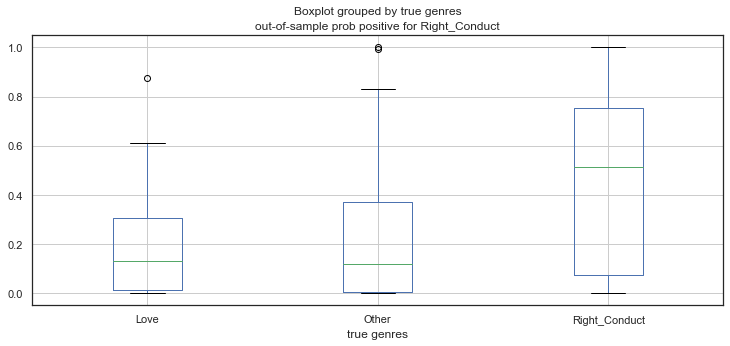

In [306]:

tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

In [307]:
target = [r['y'] for r in revtest]

accuracy 0.6148148148148148
confusion matrix
 [[24 11  9]
 [ 6 41  7]
 [ 6 13 18]]
(row=expected, col=predicted)


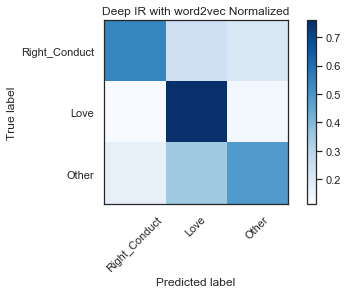

In [308]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")


### Doc2Vec 300D

In [309]:
import sys, os
# */site-packages is where your current session is running its python out of
site_path = ''
for path in sys.path:
    if 'site-packages' in path.split('/')[-1]:
        print(path)
        site_path = path
# search to see if gensim in installed packages
if len(site_path) > 0:
    if not 'gensim' in os.listdir(site_path):
        print('package not found')
    else:
        print('gensim installed') 

C:\Users\425858\AppData\Roaming\Python\Python37\site-packages
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\win32
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\win32\lib
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\Pythonwin
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions
package not found


In [310]:
df_doc2vec= df
df.head()
#df.columns = ['tag', 'plot']
df_doc2vec.columns = ['tags', 'post']
df_doc2vec.head()

,tags,post
369,Right_Conduct,To seek only your future is selfishness. To be...
131,Right_Conduct,The Purāñas (scriptures) consider moksha (libe...
324,Love,There are many ways of realising God. Among th...
653,Other,Have faith that truth will save you in the lon...
410,Other,"You may chant any Name, contemplate on any for..."


In [311]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils
import re
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df_doc2vec.post, df_doc2vec.tags, random_state=random_state, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [312]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 134463.51it/s]
2020-01-12 19:06:50,871 : INFO : collecting all words and their counts
2020-01-12 19:06:50,872 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-12 19:06:50,889 : INFO : collected 7561 word types and 674 unique tags from a corpus of 674 examples and 43918 words
2020-01-12 19:06:50,891 : INFO : Loading a fresh vocabulary
2020-01-12 19:06:50,909 : INFO : effective_min_count=1 retains 7561 unique words (100% of original 7561, drops 0)
2020-01-12 19:06:50,911 : INFO : effective_min_count=1 leaves 43918 word corpus (100% of original 43918, drops 0)
2020-01-12 19:06:50,944 : INFO : deleting the raw counts dictionary of 7561 items
2020-01-12 19:06:50,945 : INFO : sample=0.001 downsamples 46 most-common words
2020-01-12 19:06:50,946 : INFO : downsampling leaves estimated 33016 word corpus (75.2% of prior 43918)
2020-01-12 19:06:50,968 : I

2020-01-12 19:06:51,832 : INFO : training on a 43918 raw words (33671 effective words) took 0.1s, 305833 effective words/s
2020-01-12 19:06:51,834 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|███████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 1343612.59it/s]
2020-01-12 19:06:51,863 : INFO : training model with 3 workers on 7561 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-01-12 19:06:51,917 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:51,934 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:51,954 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:51,956 : INFO : EPOCH - 1 : training on 43918 raw words (33587 effective words) took 0.1s, 400066 effective words/s
2020-01-12 19:06:51,958 : INFO : training on a 43918 raw words (33587 effe

2020-01-12 19:06:52,664 : INFO : EPOCH - 1 : training on 43918 raw words (33724 effective words) took 0.1s, 499097 effective words/s
2020-01-12 19:06:52,665 : INFO : training on a 43918 raw words (33724 effective words) took 0.1s, 467013 effective words/s
2020-01-12 19:06:52,667 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 672925.71it/s]
2020-01-12 19:06:52,671 : INFO : training model with 3 workers on 7561 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-01-12 19:06:52,717 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:52,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:52,754 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:52,756 : INFO : EPOCH - 1 : training on 43918 raw words (

2020-01-12 19:06:53,460 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-12 19:06:53,462 : INFO : EPOCH - 1 : training on 43918 raw words (33672 effective words) took 0.1s, 488701 effective words/s
2020-01-12 19:06:53,463 : INFO : training on a 43918 raw words (33672 effective words) took 0.1s, 450625 effective words/s
2020-01-12 19:06:53,463 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 666421.71it/s]
2020-01-12 19:06:53,469 : INFO : training model with 3 workers on 7561 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-01-12 19:06:53,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-12 19:06:53,528 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-12 19:06:53,546 : INFO : worker thread finished; awaiting finish o

In [313]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [314]:
#Doc2Vec 300 Dimensions
#X_train, X_test, y_train, y_test format
#Doc2Vec300D - train_vectors_dbow, test_vectors_dbow, y_train, y_test

### Machine Learning Models

In [315]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from keras import layers, models, optimizers

In [316]:
# Utility function to train models

def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, valid_y)

In [317]:
#Naive Bayes - GaussianNB
accuracy = train_model(naive_bayes.GaussianNB(), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("NB, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(naive_bayes.GaussianNB(), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("NB, CBOW - WordAvg: ", accuracy)

accuracy = train_model(naive_bayes.GaussianNB(), train_regressors, train_targets, test_regressors,test_targets)
print ("NB, Doc2Vec: ", accuracy)

accuracy = train_model(naive_bayes.GaussianNB(), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("NB, Doc2Vec300D: ", accuracy)


NB, CBOW -TF-IDF:  0.4
NB, CBOW - WordAvg:  0.674074074074074
NB, Doc2Vec:  0.6148148148148148
NB, Doc2Vec300D:  0.5925925925925926


In [318]:
#Logistic Regression
accuracy = train_model(linear_model.LogisticRegression(n_jobs=1, C=1e5), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("NB, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(n_jobs=1, C=1e5), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("NB, CBOW - WordAvg: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(n_jobs=1, C=1e5), train_regressors, train_targets, test_regressors,test_targets)
print ("NB, Doc2Vec: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(n_jobs=1, C=1e5), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("NB, Doc2Vec300D: ", accuracy)

NB, CBOW -TF-IDF:  0.4148148148148148
NB, CBOW - WordAvg:  0.674074074074074
NB, Doc2Vec:  0.6296296296296297
NB, Doc2Vec300D:  0.6370370370370371


In [319]:
#SVM Linear
accuracy = train_model(svm.SVC(), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("SVM Linear, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(svm.SVC(), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("SVM Linear, CBOW - WordAvg: ", accuracy)

accuracy = train_model(svm.SVC(), train_regressors, train_targets, test_regressors,test_targets)
print ("SVM Linear, Doc2Vec: ", accuracy)

accuracy = train_model(svm.SVC(), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("SVM Linear, Doc2Vec300D: ", accuracy)

SVM Linear, CBOW -TF-IDF:  0.6
SVM Linear, CBOW - WordAvg:  0.4
SVM Linear, Doc2Vec:  0.6444444444444445
SVM Linear, Doc2Vec300D:  0.6074074074074074


In [320]:
#Random Forest
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=1000), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("Random Forest, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=1000), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("Random Forest, CBOW - WordAvg: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_regressors, train_targets, test_regressors,test_targets)
print ("Random Forest, Doc2Vec: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("Random Forest, Doc2Vec300D: ", accuracy)

Random Forest, CBOW -TF-IDF:  0.6296296296296297
Random Forest, CBOW - WordAvg:  0.6518518518518519
Random Forest, Doc2Vec:  0.6074074074074074
Random Forest, Doc2Vec300D:  0.6222222222222222


In [321]:
import pandas, xgboost, numpy, textblob, string
#Extreme Gradient Boosting
accuracy = train_model(xgboost.XGBClassifier(), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("xgBoost, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("xgBoost, CBOW - WordAvg: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("xgBoost, Doc2Vec: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("xgBoost, Doc2Vec300D: ", accuracy)

xgBoost, CBOW -TF-IDF:  0.4444444444444444
xgBoost, CBOW - WordAvg:  0.7185185185185186
xgBoost, Doc2Vec:  0.6
xgBoost, Doc2Vec300D:  0.6370370370370371


In [322]:
#KNeighborsClassifier
accuracy = train_model(KNeighborsClassifier(n_neighbors=5), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("KNN, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(KNeighborsClassifier(n_neighbors=5), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("KNN, CBOW - WordAvg: ", accuracy)

accuracy = train_model(KNeighborsClassifier(n_neighbors=5), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("KNN, Doc2Vec: ", accuracy)

accuracy = train_model(KNeighborsClassifier(n_neighbors=5), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("KNN, Doc2Vec300D: ", accuracy)

KNN, CBOW -TF-IDF:  0.48148148148148145
KNN, CBOW - WordAvg:  0.6370370370370371
KNN, Doc2Vec:  0.6222222222222222
KNN, Doc2Vec300D:  0.5851851851851851


In [323]:
#Rocchio classification
accuracy = train_model(NearestCentroid(), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("Rocchio classification, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(NearestCentroid(), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("Rocchio classification, CBOW - WordAvg: ", accuracy)

accuracy = train_model(NearestCentroid(), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("Rocchio classification, Doc2Vec: ", accuracy)

accuracy = train_model(NearestCentroid(), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("Rocchio classification, Doc2Vec300D: ", accuracy)

Rocchio classification, CBOW -TF-IDF:  0.3851851851851852
Rocchio classification, CBOW - WordAvg:  0.674074074074074
Rocchio classification, Doc2Vec:  0.5555555555555556
Rocchio classification, Doc2Vec300D:  0.6814814814814815


In [324]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
accuracy = train_model(GradientBoostingClassifier(n_estimators=100), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("Gradient Boosting, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(GradientBoostingClassifier(n_estimators=100), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("Gradient Boosting, CBOW - WordAvg: ", accuracy)

accuracy = train_model(GradientBoostingClassifier(n_estimators=100), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("Gradient Boosting, Doc2Vec: ", accuracy)

accuracy = train_model(GradientBoostingClassifier(n_estimators=100), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("Gradient Boosting, Doc2Vec300D: ", accuracy)

Gradient Boosting, CBOW -TF-IDF:  0.48148148148148145
Gradient Boosting, CBOW - WordAvg:  0.7185185185185186
Gradient Boosting, Doc2Vec:  0.6148148148148148
Gradient Boosting, Doc2Vec300D:  0.6222222222222222


In [325]:
#Meta Bagging Decision Trees
from sklearn import tree
accuracy = train_model(tree.DecisionTreeClassifier(), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("Meta Bagging Decision Trees, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(tree.DecisionTreeClassifier(), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("Meta Bagging Decision Trees, CBOW - WordAvg: ", accuracy)

accuracy = train_model(tree.DecisionTreeClassifier(), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("Meta Bagging Decision Trees, Doc2Vec: ", accuracy)

accuracy = train_model(tree.DecisionTreeClassifier(), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("Meta Bagging Decision Trees, Doc2Vec300D: ", accuracy)

Meta Bagging Decision Trees, CBOW -TF-IDF:  0.3111111111111111
Meta Bagging Decision Trees, CBOW - WordAvg:  0.5777777777777777
Meta Bagging Decision Trees, Doc2Vec:  0.562962962962963
Meta Bagging Decision Trees, Doc2Vec300D:  0.4444444444444444


In [326]:
#SVM rbf
accuracy = train_model(svm.SVC(kernel='rbf'), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("SVM rbf, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(svm.SVC(kernel='rbf'), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("SVM rbf, CBOW - WordAvg: ", accuracy)

accuracy = train_model(svm.SVC(kernel='rbf'), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("SVM rbf, Doc2Vec: ", accuracy)

accuracy = train_model(svm.SVC(kernel='rbf'), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("SVM rbf, Doc2Vec300D: ", accuracy)

SVM rbf, CBOW -TF-IDF:  0.6
SVM rbf, CBOW - WordAvg:  0.4
SVM rbf, Doc2Vec:  0.6444444444444445
SVM rbf, Doc2Vec300D:  0.6074074074074074


In [327]:
from sklearn.ensemble import AdaBoostClassifier
accuracy = train_model(AdaBoostClassifier(random_state=random_state), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("AdaBoost, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(AdaBoostClassifier(random_state=random_state), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("AdaBoost, CBOW - WordAvg: ", accuracy)

accuracy = train_model(AdaBoostClassifier(random_state=random_state), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("AdaBoost, Doc2Vec: ", accuracy)

accuracy = train_model(AdaBoostClassifier(random_state=random_state), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("AdaBoost, Doc2Vec300D: ", accuracy)

AdaBoost, CBOW -TF-IDF:  0.4222222222222222
AdaBoost, CBOW - WordAvg:  0.6370370370370371
AdaBoost, Doc2Vec:  0.6222222222222222
AdaBoost, Doc2Vec300D:  0.6666666666666666


In [328]:
#Meta Bagging Estimator with Decision Trees
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

accuracy = train_model(BaggingClassifier(tree.DecisionTreeClassifier(random_state=random_state)), X_train_W2V_TFIDF, train_data_df.tag, X_test_W2V_TFIDF,test_data_df.tag)
print ("Meta Bagging Estimator with Decision Trees, CBOW -TF-IDF: ", accuracy)

accuracy = train_model(BaggingClassifier(tree.DecisionTreeClassifier(random_state=random_state)), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)
print ("Meta Bagging Estimator with Decision Trees, CBOW - WordAvg: ", accuracy)

accuracy = train_model(BaggingClassifier(tree.DecisionTreeClassifier(random_state=random_state)), numpy.array(train_regressors), train_targets, numpy.array(test_regressors),test_targets)
print ("Meta Bagging Estimator with Decision Trees, Doc2Vec: ", accuracy)

accuracy = train_model(BaggingClassifier(tree.DecisionTreeClassifier(random_state=random_state)), train_vectors_dbow, y_train, test_vectors_dbow,y_test)
print ("Meta Bagging Estimator with Decision Trees, Doc2Vec300D: ", accuracy)

Meta Bagging Estimator with Decision Trees, CBOW -TF-IDF:  0.562962962962963
Meta Bagging Estimator with Decision Trees, CBOW - WordAvg:  0.6148148148148148
Meta Bagging Estimator with Decision Trees, Doc2Vec:  0.5925925925925926
Meta Bagging Estimator with Decision Trees, Doc2Vec300D:  0.5851851851851851


In [329]:
# Soft Voting Classifier 

In [330]:
#https://www.kaggle.com/den3b81/better-predictions-stacking-with-votingclassifier
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from xgboost import XGBClassifier

In [331]:
#Soft Voting on CBOW - WordAvg
#X_train, X_val, y_train, y_val = model_selection.train_test_split(trainDF['text'], trainDF['label'],test_size = 0.20)
#X_train, X_test, y_train, y_test
#X_train_word_average, X_test_word_average, train_data_df.tag, test_data_df.tag

#accuracy = train_model(svm.SVC(kernel='rbf'), X_train_word_average, train_data_df.tag, X_test_word_average,test_data_df.tag)

In [332]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(train_data_df.tag)
y_val = encoder.fit_transform(test_data_df.tag)

In [333]:
rf1 = BaggingClassifier(tree.DecisionTreeClassifier())
#rf1 = RandomForestClassifier(n_estimators=1000, criterion='entropy',  n_jobs = -1,  random_state=random_state)
rf1.fit(X_train_word_average, y_train)
y_val_pred = rf1.predict_proba(X_test_word_average)
log_loss(y_val, y_val_pred)

0.7389633437920823

In [334]:
rf2= RandomForestClassifier(n_estimators=1000, criterion='gini',  n_jobs = -1, random_state=random_state)
rf2.fit(X_train_word_average, y_train)
y_val_pred = rf2.predict_proba(X_test_word_average)
log_loss(y_val, y_val_pred)

0.7623487367037755

In [335]:
#gbc = GradientBoostingClassifier(random_state=random_state,n_estimators=1000)
gbc = GradientBoostingClassifier(n_estimators=1000)
gbc.fit(X_train_word_average, y_train)
y_val_pred = gbc.predict_proba(X_test_word_average)
log_loss(y_val, y_val_pred)

0.8169053812054808

In [336]:
xgb = XGBClassifier(seed=random_state,n_estimators=1000)
xgb.fit(X_train_word_average, y_train)
y_val_pred = xgb.predict_proba(X_test_word_average)
log_loss(y_val, y_val_pred)

0.8432828651458066

In [337]:
eclf = VotingClassifier(estimators=[
    ('rf1', rf1), ('rf2', rf2), ('gbc', gbc), ('xgb',xgb)], voting='soft')
eclf.fit(X_train_word_average, y_train)
y_val_pred = eclf.predict_proba(X_test_word_average)
log_loss(y_val, y_val_pred)

0.6556608890780515

In [338]:
eclf = VotingClassifier(estimators=[
    ('rf1', rf1), ('rf2', rf2), ('gbc', gbc), ('xgb',xgb)], voting='soft', weights = [4,1,1,1])
eclf.fit(X_train_word_average, y_train)
y_val_pred = eclf.predict_proba(X_test_word_average)
log_loss(y_val, y_val_pred)

0.6901546059306208

### Dimensionality Reduction

In [340]:
#PCA
#Finding N components
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std =  sc.fit_transform(X_train_word_average)
X_test_word_average = sc.fit_transform(X_test_word_average)

In [341]:
cov_matrix = np.cov(X_std.T)
print("cov_matrix shape:",cov_matrix.shape)
print("Covariance_matrix",cov_matrix)

cov_matrix shape: (300, 300)
Covariance_matrix [[ 1.00185874 -0.15066203  0.09374645 ... -0.3757456  -0.20648884
   0.17336543]
 [-0.15066203  1.00185874  0.20014483 ...  0.22449353  0.29883198
  -0.17243768]
 [ 0.09374645  0.20014483  1.00185873 ...  0.03796706  0.0720843
  -0.04876218]
 ...
 [-0.3757456   0.22449353  0.03796706 ...  1.00185873  0.21566704
  -0.05539069]
 [-0.20648884  0.29883198  0.0720843  ...  0.21566704  1.00185874
  -0.18415872]
 [ 0.17336543 -0.17243768 -0.04876218 ... -0.05539069 -0.18415872
   1.00185874]]


In [342]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[ 0.0125216  -0.09662506  0.08728111 ...  0.00424196 -0.00071317
   0.00669046]
 [ 0.11039469  0.06159863  0.0007576  ... -0.04086399  0.08365194
   0.15970416]
 [ 0.06445191  0.01872479  0.09926541 ...  0.07105485  0.06212806
   0.00688451]
 ...
 [ 0.01872378  0.11379122  0.00459143 ...  0.11245079 -0.04520286
   0.07644072]
 [ 0.06737682  0.05770368  0.02070952 ... -0.0187401   0.00927381
  -0.05528132]
 [-0.07931694 -0.00703794  0.08056377 ... -0.12127993  0.03217386
   0.10541695]]

 Eigen Values 
%s [2.89293036e+01 1.60243857e+01 1.34466754e+01 8.77511733e+00
 8.08825927e+00 7.52455072e+00 7.38495493e+00 6.55244591e+00
 6.29838247e+00 5.78976838e+00 5.45643331e+00 5.16336349e+00
 4.90636017e+00 4.43345475e+00 4.31735912e+00 4.14059049e+00
 3.83658133e+00 3.63667395e+00 3.54387319e+00 3.30166234e+00
 3.13291500e+00 3.03899117e+00 2.99003487e+00 2.92225552e+00
 2.87232762e+00 2.64476432e+00 2.63268266e+00 2.46135278e+00
 2.44703892e+00 2.33566029e+00 2.25995612e+0

In [343]:
# Make a set of (eigenvalue, eigenvector) pairs:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()
eig_pairs.reverse()
print(eig_pairs)
# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]
# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(28.929303632337284, array([ 1.25215976e-02,  1.10394689e-01,  6.44519086e-02,  5.41473737e-02,
       -8.07571280e-02,  4.51162979e-02,  1.04343135e-01, -1.29349128e-02,
        1.03684599e-01,  5.18273458e-02,  2.32723164e-02, -1.44734671e-01,
       -1.77314962e-02,  1.51626890e-02, -6.35388168e-02,  9.15155957e-02,
        1.28290798e-02,  1.13159348e-01,  3.67217167e-03, -1.00993394e-01,
       -3.37549984e-02, -3.16070724e-02,  7.67864452e-03,  1.92258359e-02,
        4.23632675e-02, -8.90353524e-02, -9.94191979e-02,  1.14012841e-02,
       -7.21246981e-02,  7.02595660e-02,  2.95686688e-02, -5.84757016e-02,
        2.86752492e-04,  6.51499500e-02,  4.39233127e-02,  2.27152296e-02,
        2.42657227e-02,  1.87280037e-03,  8.54648886e-02,  3.15705034e-02,
        9.40376521e-02,  1.37887098e-02,  1.03895294e-01, -8.51543517e-02,
        4.80833226e-02,  5.93755090e-02, -5.42904522e-02,  6.39448380e-03,
       -1.37164555e-02, -1.48287697e-02,  9.96186781e-02,  3.90774589e-02,
   

       -0.06242184,  0.02060662,  0.03392347, -0.07632535,  0.06301902]))]
Eigenvalues in descending order: 
[28.929303632337284, 16.024385689863504, 13.446675375280085, 8.775117328538359, 8.088259270931234, 7.524550720795863, 7.38495492953754, 6.552445906906186, 6.298382469307299, 5.789768378662251, 5.456433314632683, 5.163363485335398, 4.906360167733065, 4.433454746417867, 4.317359121053464, 4.140590487027403, 3.836581331115317, 3.636673950826083, 3.5438731888287394, 3.3016623443386774, 3.132915000166584, 3.0389911669791676, 2.990034873433413, 2.922255516989872, 2.872327617283106, 2.6447643205143945, 2.632682661028371, 2.46135277536789, 2.4470389155104595, 2.3356602911777773, 2.259956118854438, 2.19651826629302, 2.1387326298247324, 2.0945554244743696, 2.0059831451706707, 1.94435551950875, 1.925069133393682, 1.8731002409617443, 1.8548185663914951, 1.815045098448026, 1.7130139663641935, 1.6862301250180678, 1.629556115350069, 1.6169079973020295, 1.5973493067215805, 1.5669630541191861, 1

In [344]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 18 entries as there are 18 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 18 entries with 18 th entry 
# cumulative reaching almost 100%

In [345]:
len(cum_var_exp)

300

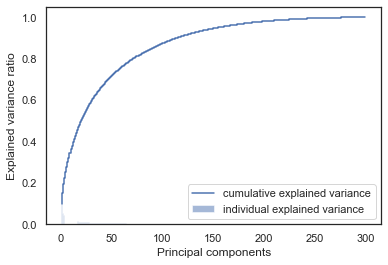

In [346]:
plt.bar(range(1,301), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,301),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

In [347]:
#- From above we plot we can clealry observer that 134 dimension() are able to explain 95 %variance of data. 
#- so we will use first 134 principal components going forward and calulate the reduced dimensions.

P_reduce = np.array(eigvectors_sorted[0:151])   # Reducing to 150 dimension space
X_std_8D = np.dot(X_std,P_reduce.T)   # projecting original data into principal component dimensions
reduced_pca = pd.DataFrame(X_std_8D)  # converting array to dataframe for pairplot
reduced_pca

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,2.923383,0.531044,3.390151,3.839814,2.194902,0.589941,-0.548748,-0.585968,3.037742,1.140220,...,0.270891,0.154232,0.115198,-0.603828,-0.041753,0.232001,0.252739,-0.502928,0.959036,-0.086697
1,3.355147,1.083004,4.439869,0.599007,-1.589638,0.195086,-0.589765,0.957325,-3.191755,-0.788216,...,1.343417,-0.728153,-0.364569,0.232279,0.258142,1.337174,0.532648,0.702556,-0.677219,0.574573
2,-5.768384,3.961892,0.390761,1.086311,0.783858,1.319263,10.079838,-5.049833,0.759306,-0.831783,...,-0.233356,-0.979767,-0.634058,1.178576,-0.234514,-1.032793,0.405600,0.125171,0.421066,-0.351260
3,-5.436870,-5.995832,-1.110033,1.474407,0.160070,-0.763235,-4.366290,-3.076547,2.480478,-2.298005,...,1.039249,0.002723,-0.426915,-0.327703,0.761753,-0.548106,-0.668080,-0.328222,-0.950177,-0.747086
4,-0.011852,5.276027,1.122571,-2.088083,-7.561951,3.698462,-0.558288,3.460895,-0.807297,-2.222311,...,0.346978,0.324976,-0.332618,-0.457889,0.497536,-0.710434,0.936002,-0.630149,-0.163720,0.858924
5,1.843025,2.417387,3.228707,-0.930720,1.639268,0.355776,6.596298,4.449001,-2.314006,-2.785403,...,0.312741,0.414665,-0.050214,-0.618859,1.620914,-0.855971,0.694736,-0.130825,-0.036505,-0.067352
6,0.653652,1.135943,-2.053244,-3.539741,-3.950789,-0.403455,-1.162472,-4.843297,6.448373,-3.199894,...,-0.180295,0.599501,-0.100078,0.392137,-0.146542,0.152993,0.443047,0.023198,-0.508749,-0.131386
7,6.551388,1.643552,-0.079735,-1.316042,-2.976136,0.648778,-1.770682,0.542235,-4.610573,3.898890,...,0.914515,0.480129,-0.054696,0.053349,-0.194485,-0.072984,-0.331951,-0.078198,0.097462,-0.085176
8,4.843083,0.445871,-4.185116,3.478237,-1.171816,1.408434,7.814107,1.967965,2.561707,-3.401882,...,-0.314482,0.521568,0.052485,0.535216,-0.057748,0.028392,0.538848,-0.104339,1.372866,0.829347
9,0.908438,0.648078,0.528453,-2.238185,1.834746,-5.180468,1.542401,1.195747,0.566451,0.620295,...,-0.015634,-0.257627,-0.723150,0.315134,0.560897,-0.290819,0.317198,-0.339214,-0.371908,0.133440


In [348]:
#sns.pairplot(reduced_pca, diag_kind='kde') 
#sns.pairplot(reduced_pca1, diag_kind='kde')

#PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [349]:
pca = PCA(n_components=135)
X_train_PCA_new = pca.fit_transform(X_train_word_average)
X_test_PCA_new = pca.fit_transform(X_test_word_average)

print("train with old features: ",np.array(X_train_word_average).shape)
print("train with new features:" ,np.array(X_train_PCA_new).shape)

print("test with old features: ",np.array(X_test_word_average).shape)
print("test with new features:" ,np.array(X_test_PCA_new).shape)

train with old features:  (539, 300)
train with new features: (539, 135)
test with old features:  (135, 300)
test with new features: (135, 135)


In [350]:
X_train, X_test, y_train, y_test
X_train_word_average, X_test_word_average, train_data_df.tag, test_data_df.tag


X_train = X_train_word_average
X_val = X_test_word_average
y_train = train_data_df.tag 
y_val = test_data_df.tag


accuracy = train_model(BaggingClassifier(tree.DecisionTreeClassifier(random_state=random_state)), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("Meta Bagging Estimator with Decision Trees, CBOW - WordAvg: ", accuracy)

accuracy = train_model(AdaBoostClassifier(random_state=random_state), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("AdaBoost, CBOW - WordAvg: ", accuracy)


accuracy = train_model(svm.SVC(kernel='rbf'), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("SVM rbf, CBOW - WordAvg: ", accuracy)


accuracy = train_model(tree.DecisionTreeClassifier(), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("Meta Bagging Decision Trees, CBOW - WordAvg: ", accuracy)


accuracy = train_model(GradientBoostingClassifier(n_estimators=100), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("Gradient Boosting, CBOW - WordAvg: ", accuracy)

accuracy = train_model(NearestCentroid(), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("Rocchio classification, CBOW - WordAvg: ", accuracy)


accuracy = train_model(KNeighborsClassifier(n_neighbors=5), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("KNN, CBOW - WordAvg: ", accuracy)


accuracy = train_model(xgboost.XGBClassifier(), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("xgBoost, CBOW - WordAvg: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=1000), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("Random Forest, CBOW - WordAvg: ", accuracy)

accuracy = train_model(svm.SVC(), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("SVM Linear, CBOW - WordAvg: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(n_jobs=1, C=1e5), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("NB, CBOW - WordAvg: ", accuracy)

accuracy = train_model(naive_bayes.GaussianNB(), X_train_PCA_new, train_data_df.tag, X_test_PCA_new,test_data_df.tag)
print ("NB, CBOW - WordAvg: ", accuracy)



Meta Bagging Estimator with Decision Trees, CBOW - WordAvg:  0.34814814814814815
AdaBoost, CBOW - WordAvg:  0.4888888888888889
SVM rbf, CBOW - WordAvg:  0.4
Meta Bagging Decision Trees, CBOW - WordAvg:  0.35555555555555557
Gradient Boosting, CBOW - WordAvg:  0.34074074074074073
Rocchio classification, CBOW - WordAvg:  0.6296296296296297
KNN, CBOW - WordAvg:  0.5333333333333333
xgBoost, CBOW - WordAvg:  0.42962962962962964
Random Forest, CBOW - WordAvg:  0.2518518518518518
SVM Linear, CBOW - WordAvg:  0.4
NB, CBOW - WordAvg:  0.4
NB, CBOW - WordAvg:  0.2740740740740741


In [351]:
#https://www.kaggle.com/den3b81/better-predictions-stacking-with-votingclassifier
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from xgboost import XGBClassifier

In [352]:
#Soft Voting
# label encode the target variable 
#encoder = preprocessing.LabelEncoder()
#y_train = encoder.fit_transform(y_train)
#y_val = encoder.fit_transform(y_val)

In [353]:
rf1 = BaggingClassifier(tree.DecisionTreeClassifier())
#rf1 = RandomForestClassifier(n_estimators=1000, criterion='entropy',  n_jobs = -1,  random_state=random_state)
rf1.fit(X_train_PCA_new, y_train)
y_val_pred = rf1.predict_proba(X_test_PCA_new)
log_loss(y_val, y_val_pred)

2.7288610980686943

In [354]:
rf2= RandomForestClassifier(n_estimators=1000, criterion='gini',  n_jobs = -1, random_state=random_state)
rf2.fit(X_train_PCA_new, y_train)
y_val_pred = rf2.predict_proba(X_test_PCA_new)
log_loss(y_val, y_val_pred)

1.1080027161211992

In [355]:
#gbc = GradientBoostingClassifier(random_state=random_state,n_estimators=1000)
gbc = GradientBoostingClassifier(n_estimators=1000)
gbc.fit(X_train_PCA_new, y_train)
y_val_pred = gbc.predict_proba(X_test_PCA_new)
log_loss(y_val, y_val_pred)
#print(y_val_pred)

5.500708392191227

In [356]:
xgb = XGBClassifier(seed=random_state,n_estimators=1000)
xgb.fit(X_train_PCA_new, y_train)
y_val_pred = xgb.predict_proba(X_test_PCA_new)
log_loss(y_val, y_val_pred)
#print(y_val_pred)


1.7218146766294484

In [357]:
eclf = VotingClassifier(estimators=[
    ('rf1', rf1), ('rf2', rf2), ('gbc', gbc), ('xgb',xgb)], voting='soft')
eclf.fit(X_train_PCA_new, y_train)
y_val_pred = eclf.predict_proba(X_test_PCA_new)
#print(y_val_pred)
log_loss(y_val, y_val_pred)

1.1948205448308824

In [358]:
eclf = VotingClassifier(estimators=[
    ('rf1', rf1), ('rf2', rf2), ('gbc', gbc), ('xgb',xgb)], voting='soft', weights = [4,1,1,1])
eclf.fit(X_train_PCA_new, y_train)
y_val_pred = eclf.predict_proba(X_test_PCA_new)
log_loss(y_val, y_val_pred)
print(y_val_pred)


[[0.3420132  0.61327237 0.04471442]
 [0.11151615 0.37684369 0.51164016]
 [0.45158121 0.3888082  0.15961059]
 [0.30731359 0.3212119  0.37147451]
 [0.33006995 0.50238635 0.1675437 ]
 [0.38512787 0.50792537 0.10694676]
 [0.18352739 0.55405252 0.26242008]
 [0.15836747 0.67232549 0.16930704]
 [0.29252136 0.36270378 0.34477485]
 [0.39341828 0.3814807  0.22510102]
 [0.32443896 0.57439554 0.10116551]
 [0.45102859 0.33053049 0.21844092]
 [0.38167565 0.39762696 0.2206974 ]
 [0.40732461 0.31428585 0.27838955]
 [0.44423768 0.39406443 0.16169789]
 [0.28137185 0.42202523 0.29660293]
 [0.53420331 0.22022852 0.24556817]
 [0.26135021 0.51645163 0.22219816]
 [0.11854903 0.54137502 0.34007595]
 [0.26481579 0.62409238 0.11109182]
 [0.22761793 0.59448203 0.17790004]
 [0.36924325 0.52881017 0.10194658]
 [0.36434619 0.40563092 0.23002289]
 [0.35991439 0.38292258 0.25716303]
 [0.38127157 0.48314024 0.1355882 ]
 [0.40838331 0.42603537 0.16558132]
 [0.15399333 0.56917314 0.27683353]
 [0.27237548 0.57935039 0.14

In [359]:
#Accuracy reduces after Dimensionality reduction

In [360]:
#Umap Dimensionality Reduction
#https://umap-learn.readthedocs.io/en/latest/basic_usage.html
#import umap do not install umap https://github.com/lmcinnes/umap/issues/24
#import umaplearn install umap-learn
#from umap import UMAP

In [361]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [362]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
import umap.umap_ as umap

In [364]:
reducer = umap.UMAP()
embedding.shape

In [365]:
embedding = reducer.fit_transform(X_train_word_average)

In [367]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(train_data_df.tag)
y_val = encoder.fit_transform(test_data_df.tag)

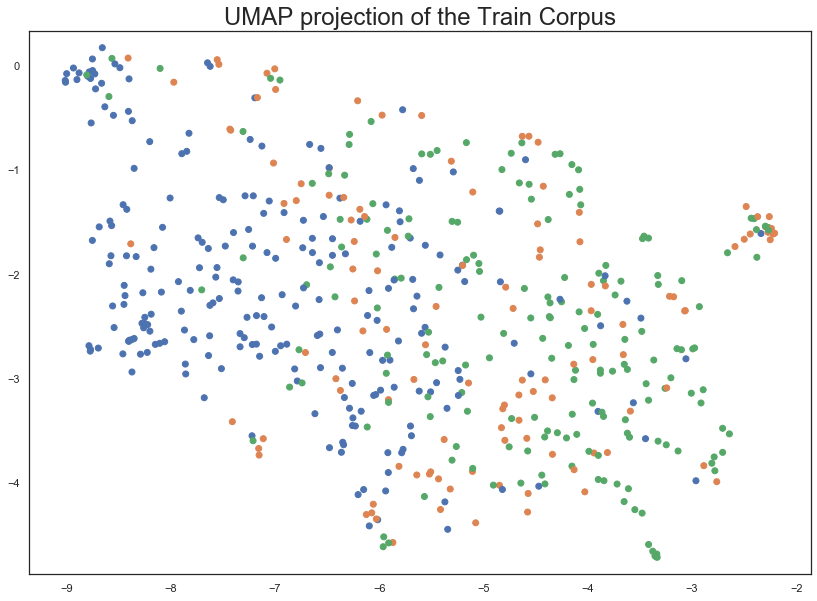

In [368]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in y_train])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Train Corpus', fontsize=24);

In [369]:
reducer = umap.UMAP(random_state=random_state)
reducer.fit(X_train_word_average)

#embedding = reducer.fit_transform(X_train_word_average)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=54321,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [370]:
embedding = reducer.transform(X_train_word_average)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(539, 2)

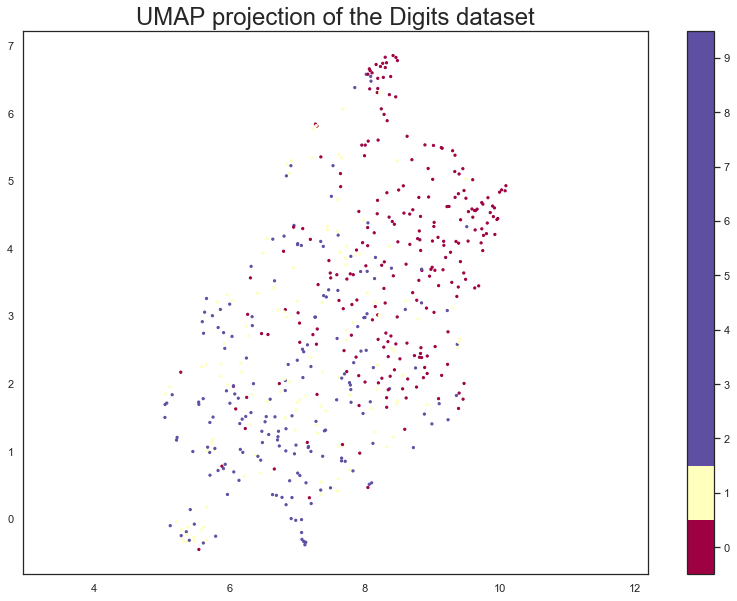

In [371]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [372]:
#Now transform Train and Test Data into Umap

In [373]:
X_train_word_average_umap = reducer.fit_transform(X_train_word_average)
X_test_word_average_umap = reducer.fit_transform(X_test_word_average )


In [374]:

accuracy = train_model(BaggingClassifier(tree.DecisionTreeClassifier(random_state=random_state)), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap ,test_data_df.tag)
print ("Meta Bagging Estimator with Decision Trees, CBOW - WordAvg: ", accuracy)

accuracy = train_model(AdaBoostClassifier(random_state=random_state), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("AdaBoost, CBOW - WordAvg: ", accuracy)


accuracy = train_model(svm.SVC(kernel='rbf'), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("SVM rbf, CBOW - WordAvg: ", accuracy)


accuracy = train_model(tree.DecisionTreeClassifier(), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("Meta Bagging Decision Trees, CBOW - WordAvg: ", accuracy)


accuracy = train_model(GradientBoostingClassifier(n_estimators=100), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("Gradient Boosting, CBOW - WordAvg: ", accuracy)

accuracy = train_model(NearestCentroid(), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("Rocchio classification, CBOW - WordAvg: ", accuracy)


accuracy = train_model(KNeighborsClassifier(n_neighbors=5), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("KNN, CBOW - WordAvg: ", accuracy)


accuracy = train_model(xgboost.XGBClassifier(), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("xgBoost, CBOW - WordAvg: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=1000), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("Random Forest, CBOW - WordAvg: ", accuracy)

accuracy = train_model(svm.SVC(), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("SVM Linear, CBOW - WordAvg: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(n_jobs=1, C=1e5), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("NB, CBOW - WordAvg: ", accuracy)

accuracy = train_model(naive_bayes.GaussianNB(), X_train_word_average_umap, train_data_df.tag, X_test_word_average_umap,test_data_df.tag)
print ("NB, CBOW - WordAvg: ", accuracy)



Meta Bagging Estimator with Decision Trees, CBOW - WordAvg:  0.32592592592592595
AdaBoost, CBOW - WordAvg:  0.6074074074074074
SVM rbf, CBOW - WordAvg:  0.32592592592592595
Meta Bagging Decision Trees, CBOW - WordAvg:  0.5925925925925926
Gradient Boosting, CBOW - WordAvg:  0.5851851851851851
Rocchio classification, CBOW - WordAvg:  0.32592592592592595
KNN, CBOW - WordAvg:  0.3925925925925926
xgBoost, CBOW - WordAvg:  0.2962962962962963
Random Forest, CBOW - WordAvg:  0.32592592592592595
SVM Linear, CBOW - WordAvg:  0.32592592592592595
NB, CBOW - WordAvg:  0.32592592592592595
NB, CBOW - WordAvg:  0.2740740740740741


In [375]:
#Auto-ML
import h2o

In [376]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,7 hours 49 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_425858_u54bh7
H2O cluster total nodes:,1
H2O cluster free memory:,1.592 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [377]:
# Identify predictors and response
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(train_data_df.tag)
y_val = encoder.fit_transform(test_data_df.tag)
#CBOW - WordAvg - X_train_word_average, X_test_word_average, train_data_df.tag, test_data_df.tag



In [243]:
#X_train_word_average = h2o.H2OFrame(X_train_word_average)
#X_test_word_average = h2o.H2OFrame(X_test_word_average)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [381]:
#len(X_train_word_average)
#len(train_data_df.tag)
#X_train_word_average = X_train_word_average + y_train


type(y_train)
type(X_train_word_average)

numpy.ndarray

In [382]:
y_train_h2o = h2o.H2OFrame(y_train)
y_val_h2o = h2o.H2OFrame(y_val)
X_train_word_average_h2o = h2o.H2OFrame(X_train_word_average)
X_test_word_average_h2o = h2o.H2OFrame(X_test_word_average)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [384]:
print(y_train_h2o.shape) #Tags
print(X_train_word_average_h2o.shape) #300 Dimensions Train data 
print(y_val_h2o.shape) #Tags
print(X_test_word_average_h2o.shape) ##300 Dimensions Test data

(539, 1)
(539, 300)
(135, 1)
(135, 300)


In [396]:
#X_train_word_average_h2o use as Predictors

X_train_h2o = y_train_h2o.cbind(X_train_word_average_h2o) 
X_test_h2o = y_val_h2o.cbind(X_test_word_average_h2o)

In [394]:
print(X_train_h2o.head)

C1,C10,C2,C3,C4,C5,C6,C7,C8,C9,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209,C210,C211,C212,C213,C214,C215,C216,C217,C218,C219,C220,C221,C222,C223,C224,C225,C226,C227,C228,C229,C230,C231,C232,C233,C234,C235,C236,C237,C238,C239,C240,C241,C242,C243,C244,C245,C246,C247,C248,C249,C250,C251,C252,C253,C254,C255,C256,C257,C258,C259,C260,C261,C262,C263,C264,C265,C266,C267,C268,C269,C270,C271,C272,C273,C274,C275,C276,C277,C278,C279,C280,C281,C282,C283,C284,C285,C286,C287,C288,C289,C290,C291,C292,C293,C294,C295,C296,C297,C298,C299,C300
0,0.100683,-0.025762,0.117277,0.122507,-0.0813847,0.0295021,0.134007,-0.000138138,0.105229,0.0439245,-0.0852595,-0.03045,0.0492038,-0.0348427,0.137114,0.0133041,0.0415919,-0.0401088,-0.0639011,-0.042967,0.0311612,0.0408889,-0.0563238,-0.00099572,-0.0679057,-0.0857804,0.0139405,0.0549333,0.0391114,-0.0496405,0.00962085,0.00260538,0.0113778,0.00834037,0.0345019,0.0858069,0.0541344,0.0358726,0.0351925,0.136464,-0.0185013,0.0196275,0.0526278,-0.00555423,0.00485037,0.00115172,0.0138365,-0.0590609,0.0172302,-0.0137302,0.026583,-0.0606548,-0.049035,0.0228033,0.0261699,-0.0324293,-0.0655402,0.0197578,-0.0116376,0.0788695,0.0367734,0.0619989,-0.120669,-0.0448805,0.0045801,-0.039587,0.0960007,-0.0549378,0.0352686,0.0164542,0.0629463,-0.0212403,0.0468054,-0.0926415,-0.114732,-0.00940972,0.0345441,0.0710241,0.120801,0.00536341,-0.00224692,0.00929004,-0.0153499,-0.052303,-0.108517,-0.0539585,0.0751758,0.0243339,0.025236,0.0366459,0.026652,-0.0641426,-0.0509391,-0.0636074,-0.0384218,0.155171,-0.00563214,-0.00505955,-0.00839531,-0.0558989,0.0518623,0.0852536,-0.0269311,0.00775165,-0.0834945,-0.0234465,-0.0210428,0.0482041,-0.054878,-0.143526,-0.0102338,0.0438148,-0.00615259,0.102199,0.026519,0.0437634,-0.0323732,0.0956556,0.0843625,-0.11863,0.0670301,-0.0756643,0.0604032,-0.0180938,-0.0239898,-0.0136518,-0.0275529,-0.015941,0.0136078,-0.0144635,-0.116301,-0.141685,0.0101642,0.127324,-0.0589515,-0.0166478,0.00484406,0.0559625,0.00969355,0.0502502,-0.0911664,0.0444159,0.00537911,0.0290347,0.0187121,0.000825175,0.0236406,-0.039088,-0.00928559,0.0944287,-0.0102209,-0.0241684,0.00600722,0.00620176,-0.0666797,-0.015664,-0.121735,0.00641122,-0.0793249,-0.0958101,-0.0464452,-0.00895199,0.0562615,-0.00953121,-0.0124265,0.0314415,-0.0272355,-0.0674638,0.0051344,-0.173516,0.00823373,-0.00958317,-0.141537,0.0604704,-0.0291259,-0.0166301,-0.112839,-0.0562312,-0.066171,-0.0454351,-0.0820019,-0.0146673,0.0309728,-0.000131408,0.0366566,-0.0324245,-0.0332168,0.0590882,0.0198714,0.0201087,-0.0110625,-0.0239279,-0.00878103,-0.0181911,-0.00163562,-0.0588571,0.0424299,-0.114683,-0.101716,-0.0257872,-0.0271728,0.0257741,-0.0407665,-0.0420106,-0.0505257,-0.00165425,0.00296554,-0.00133135,-0.0463411,-0.0328459,0.0277237,-0.0720805,-0.0523777,-0.0260145,0.0639374,0.0222421,0.0857519,-0.0925593,0.0269287,0.0201579,-0.0140468,0.0815932,-0.0546067,-0.00459193,-0.0568824,0.0930093,0.0142934,-0.0166089,0.0417817,-0.0475418,-0.0259735,-0.0200054,0.150338,0.129922,-0.0399006,0.077443,-0.0357075,0.0736258,0.0298587,0.120676,-0.0513946,-0.0353557,-0.0314612,0.0439916,0.0421119,-0.000649804,0.0249536,0.0106507,

<bound method H2OFrame.head of >


In [395]:
# Identify predictors and response
y = "C1" #response
x = X_train_h2o.columns #Predictors
x.remove(y)

In [413]:
import h2o
from h2o.automl import H2OAutoML, get_leaderboard

In [410]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
#https://github.com/h2oai/h2o-tutorials/tree/master/h2o-world-2017/automl
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=X_train_h2o)

AutoML progress: |
21:59:31.801: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\425858\\AppData\\Local\\Temp\\tmp_d788nyh.csv'
█| 100%


In [425]:
#http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html f# AutoML Leaderboard
lb = aml.leaderboard

In [422]:
# Optionally add extra model information to the leaderboard
lb = get_leaderboard(aml, extra_columns='ALL')

In [426]:
lb.head

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200112_215931,0.270359,0.51996,0.270359,0.37129,0.281255
StackedEnsemble_BestOfFamily_AutoML_20200112_215931,0.276509,0.525841,0.276509,0.40452,0.296082
DeepLearning_grid__2_AutoML_20200112_215931_model_2,0.283651,0.532589,0.283651,0.405241,0.292224
DeepLearning_grid__2_AutoML_20200112_215931_model_1,0.309462,0.556293,0.309462,0.385364,0.298545
DeepLearning_grid__3_AutoML_20200112_215931_model_1,0.319183,0.564962,0.319183,0.429541,0.315492
GBM_3_AutoML_20200112_215931,0.337152,0.580648,0.337152,0.451889,0.326125
DeepLearning_grid__1_AutoML_20200112_215931_model_2,0.33866,0.581945,0.33866,0.455829,0.348134
GBM_4_AutoML_20200112_215931,0.342194,0.584974,0.342194,0.44491,0.329287
DeepLearning_grid__1_AutoML_20200112_215931_model_1,0.350037,0.591639,0.350037,0.468693,0.358057
GLM_1_AutoML_20200112_215931,0.35048,0.592013,0.35048,0.488882,0.351714


<bound method H2OFrame.head of >

In [423]:
# Print all rows (instead of default 10 rows)
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20200112_215931,0.270359,0.51996,0.270359,0.37129,0.281255,677,1.30495
StackedEnsemble_BestOfFamily_AutoML_20200112_215931,0.276509,0.525841,0.276509,0.40452,0.296082,339,0.411077
DeepLearning_grid__2_AutoML_20200112_215931_model_2,0.283651,0.532589,0.283651,0.405241,0.292224,69510,0.367844
DeepLearning_grid__2_AutoML_20200112_215931_model_1,0.309462,0.556293,0.309462,0.385364,0.298545,37008,0.027182
DeepLearning_grid__3_AutoML_20200112_215931_model_1,0.319183,0.564962,0.319183,0.429541,0.315492,36880,0.136061
GBM_3_AutoML_20200112_215931,0.337152,0.580648,0.337152,0.451889,0.326125,1329,0.013351
DeepLearning_grid__1_AutoML_20200112_215931_model_2,0.33866,0.581945,0.33866,0.455829,0.348134,64706,0.145073
GBM_4_AutoML_20200112_215931,0.342194,0.584974,0.342194,0.44491,0.329287,1695,0.014898
DeepLearning_grid__1_AutoML_20200112_215931_model_1,0.350037,0.591639,0.350037,0.468693,0.358057,35373,0.022853
GLM_1_AutoML_20200112_215931,0.35048,0.592013,0.35048,0.488882,0.351714,76,0.007064


In [427]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20200112_215931

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.003714658853415332
RMSE: 0.06094800122576073
MAE: 0.05182723856693066
RMSLE: 0.037836399644054615
R^2: 0.9951658884236393
Mean Residual Deviance: 0.003714658853415332
Null degrees of freedom: 538
Residual degrees of freedom: 527
Null deviance: 414.18181818181887
Residual deviance: 2.002201121990864
AIC: -1460.341747415358

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.27035863509007957
RMSE: 0.5199602245269147
MAE: 0.37128954383377477
RMSLE: 0.28125517065368016
R^2: 0.6481658587688583
Mean Residual Deviance: 0.27035863509007957
Null degrees of freedom: 538
Residual degrees of freedom: 530
Null deviance: 415.6423929036896
Residual deviance: 145.7233043135529
AIC: 844.6005461610902


In [430]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

preds = aml.predict(X_test_word_average_h2o)

# or:
#preds = aml.leader.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [432]:
print(preds)

predict
-10.5993
1.99756
-2.532
-9.37932
-5.19802
-5.61138
0.875718
4.77093
-6.48698
-2.72232
